In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Set your file path
data_path = r"C:\Users\saipr\anaconda3\Food_Contamination\Kitchen Eye"

categories = ["Contaminates", "Goodimg"]  # Folder names for each class

# Image parameters
img_height, img_width = 224, 224  # MobileNetV2 default size
batch_size = 32

# Function to load images and labels
def load_images_from_folder(data_path, categories):
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
                img = image.load_img(file_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img)
                img_array = preprocess_input(img_array)  # Preprocess for MobileNetV2
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load and split the dataset
images, labels = load_images_from_folder(data_path, categories)
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=123)

# Create TensorFlow datasets for efficient loading
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).shuffle(buffer_size=1000)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

# Load the MobileNetV2 model with pre-trained weights and exclude the top layers
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of the base model
from tensorflow.keras.regularizers import l2

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (contaminated or good)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=2,           # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the frozen base model
initial_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs,callbacks=[early_stopping])



Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 914ms/step - accuracy: 0.7809 - loss: 0.7361 - val_accuracy: 0.9035 - val_loss: 0.4566
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 522ms/step - accuracy: 0.9438 - loss: 0.4065 - val_accuracy: 0.9211 - val_loss: 0.3942
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 514ms/step - accuracy: 0.9797 - loss: 0.2905 - val_accuracy: 0.8772 - val_loss: 0.4551
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 511ms/step - accuracy: 0.9710 - loss: 0.2784 - val_accuracy: 0.9649 - val_loss: 0.3283
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 505ms/step - accuracy: 0.9903 - loss: 0.2524 - val_accuracy: 0.9211 - val_loss: 0.3742
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - accuracy: 0.9874 - loss: 0.2470 - val_accuracy: 0.9123 - val_loss: 0.3782


In [49]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test accuracy: {test_acc * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.9755 - loss: 0.3265
Test accuracy: 96.49%


In [52]:
# Save the trained model in HDF5 format
model.save('model.h5')  # Replace 'my_model.h5' with your desired filename and path


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Good Food


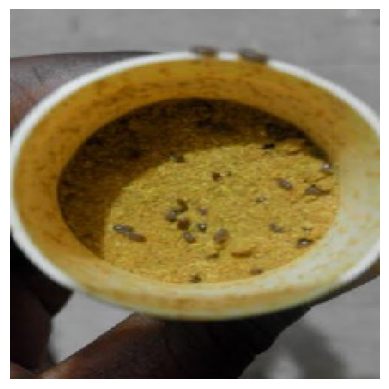

In [2]:
#Input Direct Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model (use the model path if it's saved as a .h5 file or .keras)
# If the model is saved in your directory (replace the path below with the actual model path)
model = tf.keras.models.load_model('model.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Example image path (replace with the path to your image)
img_path = "C:\\Users\\saipr\\anaconda3\\Food_Contamination\\Kitchen1\\Kitchen Eye\\contaminates\\1.jpg"

# Preprocess the image
img_array = preprocess_image(img_path)

# Make the prediction
prediction = model.predict(img_array)

# Interpret the prediction (Assuming binary classification: contaminated or good food)
if prediction[0] > 0.5:
    print("Prediction: Good Food")
else:
    print("Prediction: Contaminated Food")

# Display the image
import matplotlib.pyplot as plt
plt.imshow(img_array[0])  # img_array[0] since img_array has an extra dimension
plt.axis('off')  # Hide axis
plt.show()

In [69]:
model.save('my_model.h5')

In [7]:
import os

# Path to the folder containing images
folder_path = "C:\\Users\\saipr\\anaconda3\\Kitchen1\\Kitchen Eye\\contaminates"

# Define common image extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')

# Count images
image_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(image_extensions))

print(f"Number of images in the folder: {image_count}")


Number of images in the folder: 220


In [ ]:
#input through vedio
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('model.h5')  # Load the saved model

# Function to process and predict from a webcam frame
def predict_from_webcam(frame):
    # Resize the frame to match input size expected by the model
    img_resized = cv2.resize(frame, (224, 224))  # Resize to 224x224 as expected by MobileNetV2
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess image for MobileNetV2

    # Predict using the model
    prediction = model.predict(img_array)
    
    # Get the predicted class (0 or 1)
    predicted_class = 'Contaminates' if prediction[0] > 0.5 else 'Goodimg'
    return predicted_class

# Initialize webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam, change to 1, 2, etc. if you have multiple cameras

while True:
    ret, frame = cap.read()  # Capture frame-by-frame

    if not ret:
        break  # If frame capture failed, exit

    # Flip the frame horizontally for better user experience
    frame = cv2.flip(frame, 1)

    # Predict the class from the webcam input
    prediction = predict_from_webcam(frame)

    # Display the prediction on the webcam feed
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f'Prediction: {prediction}', (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('Webcam', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

In [ ]:
#Sound System
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from playsound import playsound
import random

# Load the trained model
model = tf.keras.models.load_model('model.h5')  # Load your trained model

# Directory for sound files
SOUND_DIR = "C:\\Users\\saipr\\anaconda3\\DeepLearning\\sound_files"

# Function to play sound (improved)
def play_random_sound():
    sound_files = [f for f in os.listdir(SOUND_DIR) if f.endswith(('.wav', '.mp3'))]
    if not sound_files:
        print("No sound files found in the directory!")
        return
    random_sound = random.choice(sound_files)
    sound_path = os.path.join(SOUND_DIR, random_sound)
    print(f"Playing sound from: {sound_path}")
    try:
        playsound(sound_path)
    except Exception as e:
        print(f"Error playing sound: {e}")

# Function to process and predict from a webcam frame
def predict_from_webcam(frame):
    # Resize and preprocess the frame
    img_resized = cv2.resize(frame, (224, 224))  # Resize to 224x224 as expected by MobileNetV2
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess image for MobileNetV2

    # Predict using the model
    prediction = model.predict(img_array)
    
    # Get the predicted class (0 or 1)
    predicted_class = 'Contaminates' if prediction[0] > 0.5 else 'Good'
    return predicted_class

# Initialize webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam

while True:
    ret, frame = cap.read()  # Capture frame-by-frame

    if not ret:
        break  # If frame capture failed, exit

    # Flip the frame horizontally for better user experience
    frame = cv2.flip(frame, 1)

    # Predict the class from the webcam input
    prediction = predict_from_webcam(frame)

    # If contaminated food is detected, play a random sound
    if prediction == 'Contaminates':
        play_random_sound()

    # Display the prediction on the webcam feed
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f'Prediction: {prediction}', (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('Webcam', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━